In [165]:
%pip install --upgrade uncertainties

Note: you may need to restart the kernel to use updated packages.


In [166]:
import caesar
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable, Table, Column
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import seaborn as sns
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from scipy.stats import binned_statistic_2d
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [167]:
def get_properties(obj):
    ''' 
    Returns the properties x-ray luminosities, stellar mass, star formation rate, specific star formation rate, 
    black hole mass, and lambda for every galaxy in the input file with stellar mass greater than 10^10 solar masses

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                          Lx : array_like
                               An array of x-ray luminosities
                stellar_mass : array_like
                               An array of stellar masses
                         SFR : array_like
                               An array of star formation rates
                        sSFR : array_like
                               An array of specific star formation rates
                     bh_mass : array_like
                               An array of black hole masses
                       lmbda : array_like
                               An array of lambda
                        Ledd : array_like
                               An array of eddington accretion
    '''
    
    # get Lx
    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # finding Ledd
    Ledd = bhmdot/bh_fedd
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    
    
    
    
    # extract galaxy mass data
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]
    all_sm = np.array(galaxy_masses)
    sm_gt10 = (all_sm > 10**10)
    stellar_mass = all_sm[sm_gt10]
    
    # masking Lx for corresponding stellar masses > 10^10
    Lx = Lx[sm_gt10]
    
    # masking Ledd for corresponding stellar masses > 10^10
    Ledd = Ledd[sm_gt10]
    
    # masking fedd for corresponding stellar masses > 10^10
    bh_fedd = bh_fedd[sm_gt10]
    
    bhmdot = bhmdot[sm_gt10]
    
    # extract star formation rates data
    galaxy_SFRs = [i.sfr for i in obj.galaxies]
    SFR = np.array(galaxy_SFRs)
    SFR = SFR[sm_gt10]
    
    # extract black hole mass data
    bh_masses = [i.masses['bh'] for i in obj.galaxies]
    bh_mass = np.array(bh_masses)
    bh_mass = bh_mass[sm_gt10]
    
    # calculate specific star formation rate
    sSFR = SFR/stellar_mass
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*stellar_mass)  
    
    
    return Lx, stellar_mass, SFR, sSFR, bh_mass, lmbda, Ledd, bh_fedd, bhmdot

In [168]:
# a list of the different redshifted files I want to load (box size 100)
files = ['m100n1024_056.hdf5',
'm100n1024_066.hdf5',
'm100n1024_074.hdf5',
'm100n1024_084.hdf5',
'm100n1024_097.hdf5',
'm100n1024_114.hdf5',
'm100n1024_137.hdf5']
files.reverse()

In [169]:
def get_all_r():
    # define input file
    # box 25
    #folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
    #box 100
    folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

    # empty dictionary to place redshift table data into
    all_r = {}

    for filename in files:
        # load in input file
        obj = caesar.load(os.path.join(folder_path, filename))

        # obtaining the properties
        Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR = get_properties(obj)

        # finding the z label
        label = filename.split('m100n1024_')[1].split('.hdf5')[0]

        # creating a table for each redshift, putting it in the empty dictionary, and naming them
        name = str('z') + str(label)
        all_r[name] = astropy.table.Table([Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR], 
                                          names=('Lx', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda', 'Ledd', 'fedd', 'BHAR'))
        
    return all_r
    

    

In [170]:
def find_fracs(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > 1e42)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > 1e42)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [171]:
#0.01
z = [0.25, 0.75, 1.25, 1.75, 2.25]
jSFR_bins = np.reshape(np.flip(np.array([2.525, 1.98, 1.289, 0.32, -0.703, 2.126, 1.739, 0.98, -0.017, 
          -1.022, 1.833, 1.433, 0.703, -0.378, -1.519, 1.564, 1.088, 0.467, 
          -0.716, -1.932, 1.196, 0.651, 0.08, -0.884, -2.636])), (5,5))
jAGN_fracs_gt2 = np.reshape(np.flip(np.array([23.992, 12.484, 23.354, 13.015, 10.793, 9.974, 10.638,
         16.218, 8.192, 4.12, 9.142, 6.743, 13.323, 4.89, 2.501,
         5.931, 3.617, 5.843, 1.469, 0.934, 3.525, 1.153, 0.696,
         0.418, 0.218])), (5,5))
#0.1
jAGN_fracs_gt1 = np.reshape(np.flip(np.array([13.02, 2.62, 7.133, 3.277, 1.071, 2.87, 1.598, 3.611, 1.349,
          0.4, 2.335, 1.025, 1.635, 0.414, 0.144, 1.48, 0.249, 0.387,
          0.148, 0.025, 0.905, 0.056, 0.046, 0.085, 0.027])), (5,5))

lo_err_gt1 = np.array([2.505, 0.336, 1.089, 0.895, 0.407, 0.445, 0.166, 0.477, 0.283, 0.128, 0.337,
                       0.099, 0.271, 0.109, 0.053, 0.294, 0.037, 0.089, 0.05, 0.014, 0.417, 0.03,
                       0.03, 0.054, 0.018])
hi_err_gt1 = np.array([2.631, 0.392, 1.26, 1.091, 0.57, 0.508, 0.17, 0.57, 0.316, 0.183, 0.389, 0.103,
                       0.318, 0.135, 0.074, 0.368, 0.045, 0.12, 0.077, 0.027, 0.754, 0.053, 0.068,
                       0.144, 0.048])



lo_err_gt2 = np.array([3.788, 1.278, 2.644, 2.957, 2.586, 1.641, 0.796, 1.69, 1.202, 0.843, 1.242,
                       0.381, 1.063, 0.678, 0.423, 0.814, 0.214, 0.492, 0.277, 0.169, 1.189, 0.208,
                       0.196, 0.182, 0.082])
hi_err_gt2 = np.array([4.416, 1.335, 2.808, 3.261, 3.153, 1.675, 0.784, 1.791, 1.245, 0.947, 1.379,
                       0.402, 1.124, 0.788, 0.501, 0.897, 0.218, 0.492, 0.327, 0.198, 1.544, 0.229,
                       0.25, 0.284,0.125])


lo_err_gt1 = np.flip(lo_err_gt1)
lo_err_gt2 = np.flip(lo_err_gt2)

hi_err_gt1 = np.flip(hi_err_gt1)
hi_err_gt2 = np.flip(hi_err_gt2)
#print(np.split(lo_err_gt1, 5))

lo_err_gt1 = np.split(lo_err_gt1, 5)
lo_err_gt2 = np.split(lo_err_gt2, 5)

hi_err_gt1 = np.split(hi_err_gt1, 5)
hi_err_gt2 = np.split(hi_err_gt2, 5)

err_bounds_allz = []
lo_bounds_allz = []
up_bounds_allz = []
for z in range(len(jAGN_fracs_gt2)):
    jfracs2_lo = unumpy.uarray((jAGN_fracs_gt2[z], lo_err_gt2[z]))  
    jfracs1_lo = unumpy.uarray((jAGN_fracs_gt1[z], lo_err_gt1[z]))
    vari_lo = jfracs1_lo/jfracs2_lo
    prop_err_lo = unumpy.std_devs(vari_lo)

    jfracs2_hi = unumpy.uarray((jAGN_fracs_gt2[z], hi_err_gt2[z]))  
    jfracs1_hi = unumpy.uarray((jAGN_fracs_gt1[z], hi_err_gt1[z]))
    vari_hi = jfracs1_hi/jfracs2_hi
    prop_err_hi = unumpy.std_devs(vari_hi)

    err_bounds = np.vstack((prop_err_lo,prop_err_hi))
    
    lo_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] - err_bounds[0]
    up_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] + err_bounds[1]
    
    err_bounds_allz.append(err_bounds)
    lo_bounds_allz.append(lo_bounds)
    up_bounds_allz.append(up_bounds)

/tmp/ipykernel_573497/1671783491.py:49: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs2_lo = unumpy.uarray((jAGN_fracs_gt2[z], lo_err_gt2[z]))
/tmp/ipykernel_573497/1671783491.py:50: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs1_lo = unumpy.uarray((jAGN_fracs_gt1[z], lo_err_gt1[z]))
/tmp/ipykernel_573497/1671783491.py:54: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs2_hi = unumpy.uarray((jAGN_fracs_gt2[z], hi_err_gt2[z]))
/tmp/ipykernel_573497/1671783491.py:55: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirector

In [172]:
all_r = get_all_r()
#print(all_r)

yt : [INFO     ] 2023-03-18 17:17:23,723 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-03-18 17:17:23,769 Found 482650 halos
yt : [INFO     ] 2023-03-18 17:17:23,782 Found 49752 galaxies
/tmp/ipykernel_573497/4053297392.py:37: RuntimeWarning: invalid value encountered in true_divide
  Ledd = bhmdot/bh_fedd
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_573497/4053297392.py:54: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-03-18 17:17:28,617 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-03-18 17:17:28,647 Found 517907 halos
yt : [INFO     ] 2023-03-18 17:17:28,655 Found 41585 galaxies
yt : [INFO     ] 2023-03-18 17:17:31,677

In [173]:
def agn_fracs(sigma):
    
        #all_r = get_all_r()
        z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

        # lists to store the 6 agn fractions (each redshift)
        AGN_fracs_gt2 = []
        AGN_fracs_gt1 = []

        # list to store the 6 sfr bin midpoints for plotting
        SFR_bins = []

        #iterating across each redshift
        for count, key in enumerate(all_r):

            #
            AGN_frac_per_bin_gt2 = np.array([])
            AGN_frac_per_bin_gt1 = np.array([])

            #extract xray luminosities to make mask Lx> 10^42
            Lx = all_r[key]['Lx'].copy()

            no_zeros = (Lx!=0)

            Lx = Lx[no_zeros]

            sm = all_r[key]['sm'][no_zeros].copy()
            logsm = np.log10(sm.data)

            # NEW WAY: binning the mass data
            #extracting the sfrs for this redshift
            SFRs_all = all_r[key]['SFR'][no_zeros].copy()
            SFRs = SFRs_all

            #creating an empty array with the size equal to the amount of 0 sfr values
            rand_sams = np.zeros(SFRs[SFRs == 0].shape)

            #filling the empty array with random numbers ranging between 0.000001 and 0.00001
            for i in range(len(rand_sams)):
                rand_sams[i] = np.random.uniform(1e-3, 1e-2)

            #replacing 0 sfr values with the randomly sampled low values
            SFRs[SFRs == 0] = rand_sams

            #logging the full sfr array with 0 values replaced
            logSFRs = np.log10(np.asarray(SFRs))

            #calculating relative MS values
            logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])

            #defining bin boundaries
            bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]

            #binning data based on relative MS values
            digitized = np.digitize(logSFR_MS, bins)

            # finding plotting points
            SFRs_midpoints = np.array([])

            # iterating across each bin
            for i in range(1, len(bins)):
                # finding the lambdas in a certain bin
                lmbda = all_r[key]['lambda'][no_zeros].copy()
                lambdas = np.log10(lmbda[digitized == i])

                #plt.hist(lambdas, bins=100)
                #plt.show()


                '''        
                #ADDING SCATTER
                '''
                mu = np.mean(lambdas)
                #sigma = sigma

                #print('loglams:', lambdas)
                #print('mean:', mu)
                #print('stdev:', sigma)

                #print(lambdas.size)
                np.random.seed(999)
                new_lambdas = lambdas + np.random.normal(0, sigma, lambdas.size)
                #new_lambdas = np.random.poisson(mu, lambdas.size)


                # finding the Lxs in a certain bin
                Lx_binned = Lx[digitized == i]
                # finding the agn fractions (2) for a certain bin
                frac_gt2, frac_gt1 = find_fracs(new_lambdas, Lx_binned)

                #binning sfrs
                #sfr_binned = logSFRs[digitized == i]
                relative_sfr = logSFR_MS[digitized == i]
                #SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))
                SFRs_midpoints = np.append(SFRs_midpoints, np.median(relative_sfr))

                #adding the agn fraction of each bin to an array length 5 (no of bins)
                AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
                AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)



            SFR_bins.append(SFRs_midpoints)
            # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
            AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
            AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
            
            #this might not work becayse the redshift lists are different lengths
            #fracs2 = np.array(AGN_fracs_gt2)
            #fracs1 = np.array(AGN_fracs_gt1)
            
            #variations = fracs1/fracs2
            #print(variations)
            
        return AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins

In [174]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

orange = matplotlib.colors.ColorConverter.to_rgb("#ff7f0e")
#blue = matplotlib.colors.ColorConverter.to_rgb("#1f77b4")
green = matplotlib.colors.ColorConverter.to_rgb("#2ca02c")
#purple = matplotlib.colors.ColorConverter.to_rgb("#9467bd")
#red = matplotlib.colors.ColorConverter.to_rgb('#d62728')
#pink = matplotlib.colors.ColorConverter.to_rgb('#e377c2')

blue = matplotlib.colors.ColorConverter.to_rgb('blue')
purple = matplotlib.colors.ColorConverter.to_rgb("darkviolet")
pink = matplotlib.colors.ColorConverter.to_rgb('fuchsia')
red = matplotlib.colors.ColorConverter.to_rgb('red')
darkred = matplotlib.colors.ColorConverter.to_rgb('darkred')

In [175]:
AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins = agn_fracs(0.263)
AGN_fracs_gt20, AGN_fracs_gt10, SFR_bins0 = agn_fracs(0)

In [176]:
print(jAGN_fracs_gt2)
#print(AGN_fracs_gt1)

[[ 0.218  0.418  0.696  1.153  3.525]
 [ 0.934  1.469  5.843  3.617  5.931]
 [ 2.501  4.89  13.323  6.743  9.142]
 [ 4.12   8.192 16.218 10.638  9.974]
 [10.793 13.015 23.354 12.484 23.992]]


In [177]:
AGN_fracs_gt2 = np.asarray(AGN_fracs_gt2)
AGN_fracs_gt1 = np.asarray(AGN_fracs_gt1)
print(AGN_fracs_gt1)

[[ 1.6007533          nan         nan         nan]
 [23.40966921  2.60186549  0.23980815  0.13101867]
 [39.45868946 13.02631579  0.69348128  2.19646126]
 [50.82508251 25.23809524  2.86123033  5.35455861]
 [60.90225564 34.79820628  8.79310345  6.20689655]
 [63.63636364 41.31627057 16.78321678  8.33333333]
 [71.42857143 56.21890547 30.39772727 17.30769231]]


In [178]:
print(AGN_fracs_gt2[1:5, 0])

[80.74639525 92.87749288 97.68976898 94.73684211]


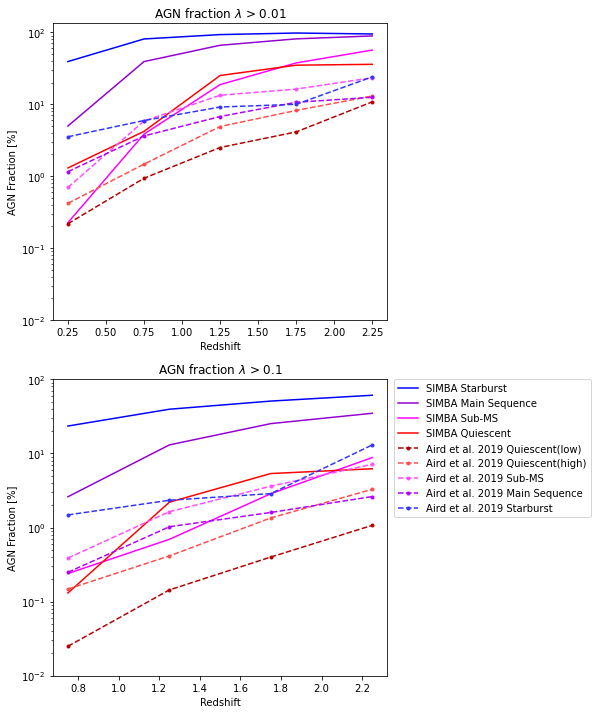

In [179]:
#with scatter
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])
redshift = np.array([0.25, 0.75, 1.25, 1.75, 2.25])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

#ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(redshift,  AGN_fracs_gt2[:5, 0], linestyle='-', color=blue,  label='SIMBA Starburst')
ax1.plot(redshift,  AGN_fracs_gt2[:5, 1], linestyle='-', color=purple, label='SIMBA Main Sequence')
ax1.plot(redshift,  AGN_fracs_gt2[:5, 2], linestyle='-', color=pink,  label='SIMBA Sub-MS')
ax1.plot(redshift,  AGN_fracs_gt2[:5, 3], linestyle='-', color=red,  label=' SIMBA Quiescent')




ax1.plot(redshift,  jAGN_fracs_gt2[:5, 0], linestyle='--', color=scale_lightness(darkred, 1.3), marker='.', label='Aird et al. 2019 Quiescent(low)')
ax1.plot(redshift,  jAGN_fracs_gt2[:5, 1], linestyle='--', color=scale_lightness(red, 1.3), marker='.', label='Aird et al. 2019 Quiescent(high)')
ax1.plot(redshift,  jAGN_fracs_gt2[:5, 2], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 Sub-MS')
ax1.plot(redshift,  jAGN_fracs_gt2[:5, 3], linestyle='--', color=scale_lightness(purple, 1.2), marker='.', label='Aird et al. 2019 Main Sequence')
ax1.plot(redshift,  jAGN_fracs_gt2[:5, 4], linestyle='--', color=scale_lightness(blue, 1.2), marker='.', label='Aird et al. 2019 Starburst')

ax1.xaxis.set_label_text('Redshift')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

#ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(redshift[1:],  AGN_fracs_gt1[1:5, 0], linestyle='-', color=blue, label='SIMBA Starburst')
ax2.plot(redshift[1:],  AGN_fracs_gt1[1:5, 1], linestyle='-', color=purple, label='SIMBA Main Sequence')
ax2.plot(redshift[1:],  AGN_fracs_gt1[1:5, 2], linestyle='-', color=pink, label='SIMBA Sub-MS')
ax2.plot(redshift[1:],  AGN_fracs_gt1[1:5, 3], linestyle='-', color=red,  label='SIMBA Quiescent')




ax2.plot(redshift[1:],  jAGN_fracs_gt1[1:5, 0], linestyle='--', color=scale_lightness(darkred, 1.3),  marker='.', label='Aird et al. 2019 Quiescent(low)')
ax2.plot(redshift[1:],  jAGN_fracs_gt1[1:5, 1], linestyle='--', color=scale_lightness(red, 1.3),  marker='.', label='Aird et al. 2019 Quiescent(high)')
ax2.plot(redshift[1:],  jAGN_fracs_gt1[1:5, 2], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 Sub-MS')
ax2.plot(redshift[1:],  jAGN_fracs_gt1[1:5, 3], linestyle='--', color=scale_lightness(purple, 1.2), marker='.', label='Aird et al. 2019 Main Sequence')
ax2.plot(redshift[1:],  jAGN_fracs_gt1[1:5, 4], linestyle='--', color=scale_lightness(blue, 1.2), marker='.', label='Aird et al. 2019 Starburst')


ax2.xaxis.set_label_text('Redshift')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

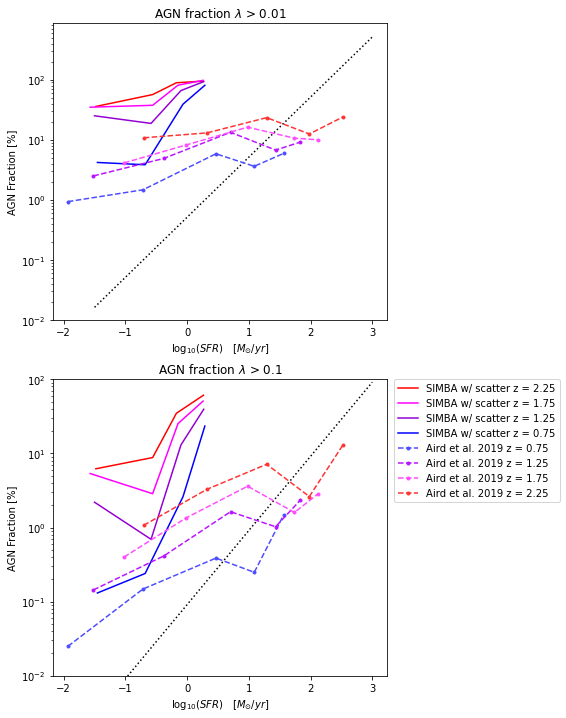

In [180]:
#with scatter
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red,  label='SIMBA w/ scatter z = 2.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple,  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue,  label=' SIMBA w/ scatter z = 0.75')




ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red, label='SIMBA w/ scatter z = 2.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple, label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue,  label='SIMBA w/ scatter z = 0.75')




ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

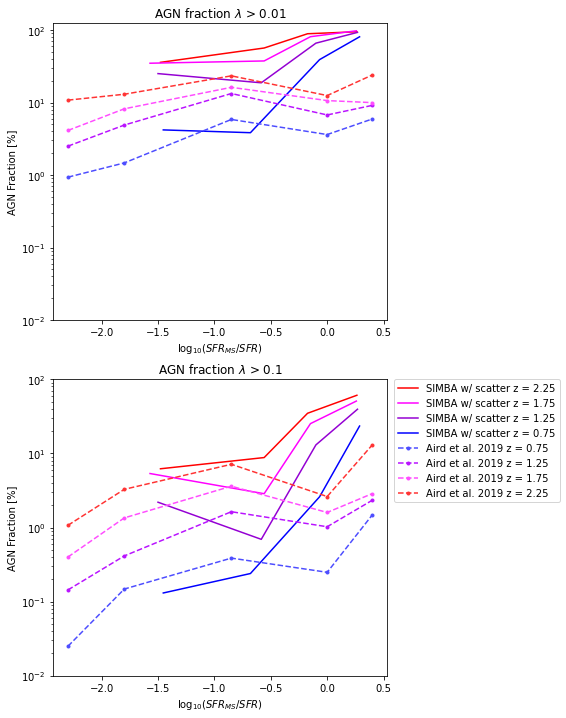

In [181]:
#plotted against log(sfr_ms/sfr)
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])
#jx = np.array([1.2, 1.2, 1.2, 1.2], [0.4, 0.4, 0.4, 0.4], [-0.85, -0.85, -0.85, -0.85], [-1.8, -1.8, -1.8, -1.8], 
#              [-3.65, -3.65, -3.65, -3.65])
jx = np.array([-2.3,-1.8,-0.85,0,0.4])
#could get better relative sfr_ms values for jdata but dont have individual points stellar masses so ive just 
#estimated them based on the boundaries for defining galaxy populations

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

#ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red,  label='SIMBA w/ scatter z = 2.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple,  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue,  label=' SIMBA w/ scatter z = 0.75')




ax1.plot(jx,  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jx,  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jx,  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jx,  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR_{MS}/SFR)$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

#ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red, label='SIMBA w/ scatter z = 2.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple, label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue,  label='SIMBA w/ scatter z = 0.75')




ax2.plot(jx,  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jx,  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jx,  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jx,  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR_{MS}/SFR)$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

In [182]:
print(SFR_bins)

[array([ 0.31371101, -0.09412287, -0.72109102, -1.46661127]), array([ 0.28728776, -0.0672725 , -0.68076049, -1.45392556]), array([ 0.26889729, -0.1001112 , -0.58478204, -1.50077565]), array([ 0.25867816, -0.14816551, -0.55921335, -1.57153835]), array([ 0.26367883, -0.17410496, -0.55906898, -1.47887236]), array([ 0.22331839, -0.22912577, -0.58517282, -1.34490698]), array([ 0.1716064 , -0.23674139, -0.6362361 , -1.17094252])]


In [183]:
SFR_bins = np.asarray(SFR_bins)
print(SFR_bins)

[[ 0.31371101 -0.09412287 -0.72109102 -1.46661127]
 [ 0.28728776 -0.0672725  -0.68076049 -1.45392556]
 [ 0.26889729 -0.1001112  -0.58478204 -1.50077565]
 [ 0.25867816 -0.14816551 -0.55921335 -1.57153835]
 [ 0.26367883 -0.17410496 -0.55906898 -1.47887236]
 [ 0.22331839 -0.22912577 -0.58517282 -1.34490698]
 [ 0.1716064  -0.23674139 -0.6362361  -1.17094252]]


In [184]:
print(SFR_bins[1:5, 0])

[0.28728776 0.26889729 0.25867816 0.26367883]


In [185]:
sfr = all_r['z056']['SFR']
logsfr = np.log10(sfr[sfr != 0])

sm = all_r['z056']['sm'][sfr != 0]
logsm = np.log10(sm)

lmbda = all_r['z056']['lambda'][sfr != 0]

for i in range(len(lmbda)):
    if lmbda[i] == 0:
        lmbda[i] = 1e-4

loglmbda = np.log10(lmbda)

Lx = all_r['z056']['Lx'][sfr != 0]

for i in range(len(Lx)):
    if Lx[i] == 0:
        Lx[i] = 1e-1
        
logLx = np.log10(Lx)

In [186]:
x_points = np.array([10, 10.5, 11, 11.5, 12, 12.5])
z = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5])
z = np.ones((6,7))*z
z=z.T
starburst_boundary = 0.15 - 7.6 + 0.76*x_points + 2.95*np.log10(1+z)
mainseq_boundary = -0.4 - 7.6 + 0.76*x_points + 2.95*np.log10(1+z)
qu_bounday = -0.95 - 7.6 + 0.76*x_points + 2.95*np.log10(1+z)

In [187]:
print(starburst_boundary)

[[0.43588454 0.81588454 1.19588454 1.57588454 1.95588454 2.33588454]
 [0.86696224 1.24696224 1.62696224 2.00696224 2.38696224 2.76696224]
 [1.18893843 1.56893843 1.94893843 2.32893843 2.70893843 3.08893843]
 [1.44603145 1.82603145 2.20603145 2.58603145 2.96603145 3.34603145]
 [1.66005591 2.04005591 2.42005591 2.80005591 3.18005591 3.56005591]
 [1.84339224 2.22339224 2.60339224 2.98339224 3.36339224 3.74339224]
 [2.07697692 2.45697692 2.83697692 3.21697692 3.59697692 3.97697692]]


In [188]:
def get_binned_fracs(y):
    logsfr_arr = np.asarray(logsfr)
    index = np.where(np.in1d(logsfr_arr, y))[0]
    frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
    return frac_gt2, frac_gt1

def get_frac1(y):
    frac2, frac1 = get_binned_fracs(y)
    return frac1

def get_frac2(y):
    frac2, frac1 = get_binned_fracs(y)
    return frac2



In [189]:
def find_fracs3(lambdas, Lx, threshold):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                     Lx : array_like
                          An array of log(Lx)
              threshold : integer
                          The threshold that log(Lx) is being tested against eg. (38, 39, 40 etc.)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > threshold)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > threshold)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    return frac_gt2, frac_gt1

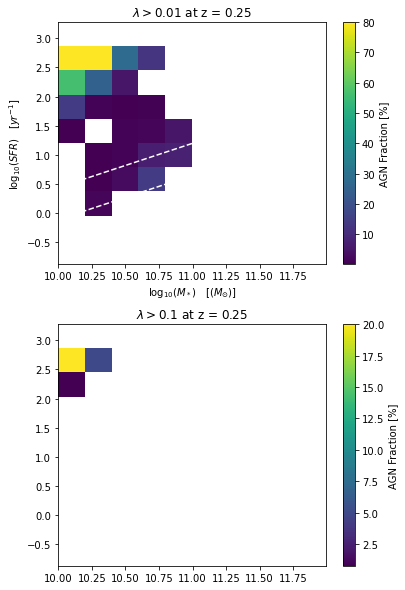

In [190]:
ret1_statT = []
ret2_statT = []

for count, key in enumerate(all_r):
    sfr = all_r[key]['SFR'].copy()
    logsfr = np.log10(sfr[sfr != 0])

    sm = all_r[key]['sm'][sfr != 0].copy()
    logsm = np.log10(sm)

    lmbda = all_r[key]['lambda'][sfr != 0].copy()

    for i in range(len(lmbda)):
        if lmbda[i] == 0:
            lmbda[i] = 1e-4

    loglmbda = np.log10(lmbda)

    Lx = all_r[key]['Lx'][sfr != 0].copy()

    for i in range(len(Lx)):
        if Lx[i] == 0:
            Lx[i] = 1e-1

    logLx = np.log10(Lx)
    
    def get_binned_fracs(y):
        logsfr_arr = np.asarray(logsfr)
        index = np.where(np.in1d(logsfr_arr, y))[0]
        frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
        return frac_gt2, frac_gt1
    
    def get_frac1(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac1', frac1)
        return frac1

    def get_frac2(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac2', frac2)
        return frac2

    ret1 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac1, bins=10)
    ret2 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac2, bins=10)
    #print(ret1)
    
    ret1_statT.append(ret1.statistic.T)
    ret2_statT.append(ret2.statistic.T)
    
#print(ret1_statT)


    

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))
fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.25)
cmap = plt.cm.get_cmap('viridis',1000)

#ax1.imshow(ret2_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4)
ax1.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
ax1.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
ax1.plot(x_points, qu_bounday[0], color='white', linestyle='--')
ax1.set_title('$\lambda > 0.01$ at z = 0.25')
im1 = ax1.imshow(ret2_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4)

#ax2.imshow(ret1_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4)
ax2.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
ax2.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
ax2.plot(x_points, qu_bounday[0], color='white', linestyle='--')
ax2.set_title('$\lambda > 0.1$ at z = 0.25')
im2 = ax2.imshow(ret1_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.4)

ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
ax1.set_ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')
#plt.title('$\lambda > 0.1$ at z = 3.5')
#plt.colorbar(im1, label='AGN Fraction [%]', ax=ax1, fraction=0.046, pad=0.04)
#plt.colorbar(im2, label='AGN Fraction [%]', ax=ax2, fraction=0.046, pad=0.04)

#cax1 = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
#cax2 = fig.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.02,ax2.get_position().height])

#divider1 = make_axes_locatable(ax1)
#cax1 = divider1.append_axes('right', size='5%', pad=0.05)
#divider2 = make_axes_locatable(ax2)
#cax2 = divider2.append_axes('right', size='5%', pad=0.05)
ax1.set_aspect('auto')
ax2.set_aspect('auto')

plt.colorbar(im1, label='AGN Fraction [%]', ax=ax1)
plt.colorbar(im2, label='AGN Fraction [%]', ax=ax2)
#fig.tight_layout()
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.show()

In [191]:
def plot(ax, z_index, ret_frac):
    ax.plot(x_points, starburst_boundary[z_index], color='white', linestyle='--')
    ax.plot(x_points, mainseq_boundary[z_index], color='white', linestyle='--')
    ax.plot(x_points, qu_bounday[z_index], color='white', linestyle='--')
    ax.set_title('$\lambda > 0.01$ at z = 0.25')
    im = ax.imshow(ret_frac[z_index], origin='lower', extent=(10,12.5,min_sfr[z_index],max_sfr[z_index]), cmap=cmap, aspect=0.5)
    cax = ax.inset_axes([1.04, 0, 0.05, 1])
    plt.colorbar(im, label='AGN Fraction [%]', cax=cax)
    #ax.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
    #ax.set_ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')


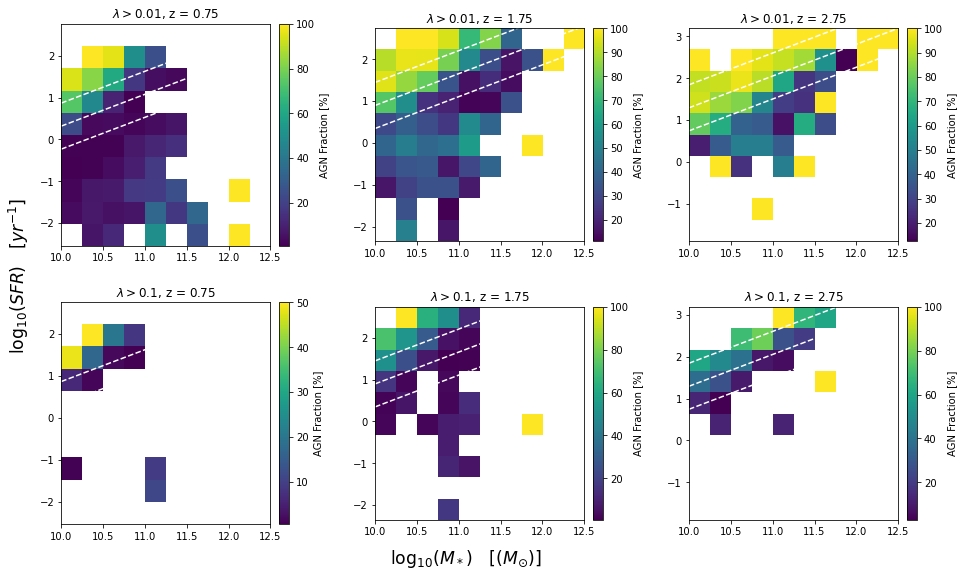

In [192]:
ret1_statT = []
ret2_statT = []

min_sfr = []
max_sfr = []
max_sm = []

for count, key in enumerate(all_r):
    #print('z:', key)
    sfr = all_r[key]['SFR'].copy()
    logsfr = np.log10(sfr[sfr != 0])
    #print('min sfr', np.min(logsfr))
    #print('max sfr', np.max(logsfr))
    
    min_sfr.append(np.min(logsfr))
    max_sfr.append(np.max(logsfr))

    sm = all_r[key]['sm'][sfr != 0].copy()
    logsm = np.log10(sm)
    
    max_sm.append(np.max(logsm))

    lmbda = all_r[key]['lambda'][sfr != 0].copy()

    for i in range(len(lmbda)):
        if lmbda[i] == 0:
            lmbda[i] = 1e-4

    loglmbda = np.log10(lmbda)

    Lx = all_r[key]['Lx'][sfr != 0].copy()

    for i in range(len(Lx)):
        if Lx[i] == 0:
            Lx[i] = 1e-1

    logLx = np.log10(Lx)
    
    def get_binned_fracs(y):
        logsfr_arr = np.asarray(logsfr)
        index = np.where(np.in1d(logsfr_arr, y))[0]
        frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
        return frac_gt2, frac_gt1
    
    def get_frac1(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac1', frac1)
        return frac1

    def get_frac2(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac2', frac2)
        return frac2

    ret1 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac1, bins=10)
    ret2 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac2, bins=10)
    #print(ret1)
    
    ret1_statT.append(ret1.statistic.T)
    ret2_statT.append(ret2.statistic.T)
    
#print(ret1_statT)

#max_sfr[5] = 4

fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.05)
cmap = plt.cm.get_cmap('viridis',1000)

#ax1.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
#ax1.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
#ax1.plot(x_points, qu_bounday[0], color='white', linestyle='--')

#im1 = ax1.imshow(ret2_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.5)
plot(ax1, 1, ret2_statT)
plot(ax2, 1, ret1_statT)

plot(ax3, 3, ret2_statT)
plot(ax4, 3, ret1_statT)

plot(ax5, 5, ret2_statT)
plot(ax6, 5, ret1_statT)
#ax2.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
#ax2.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
#ax2.plot(x_points, qu_bounday[0], color='white', linestyle='--')
ax1.set_title('$\lambda > 0.01$, z = 0.75')
ax2.set_title('$\lambda > 0.1$, z = 0.75')

ax3.set_title('$\lambda > 0.01$, z = 1.75')
ax4.set_title('$\lambda > 0.1$, z = 1.75')

ax5.set_title('$\lambda > 0.01$, z = 2.75')
ax6.set_title('$\lambda > 0.1$, z = 2.75')
#im2 = ax2.imshow(ret1_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.5)

#ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
#ax1.set_ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')

#cax1 = ax1.inset_axes([1.04, 0, 0.05, 1])
#cax2 = ax2.inset_axes([1.04, 0, 0.05, 1])

#plt.colorbar(im1, label='AGN Fraction [%]', cax=cax1)
#plt.colorbar(im2, label='AGN Fraction [%]', cax=cax2)

fig.text(0.5, 0.1, '$\log_{10}(M_*) \quad [(M_{\odot})]$', ha='center', fontsize='xx-large')
fig.text(0.075, 0.5, '$\log_{10}(SFR) \quad [yr^{-1}]$', va='center', rotation='vertical', fontsize='xx-large')

plt.show()

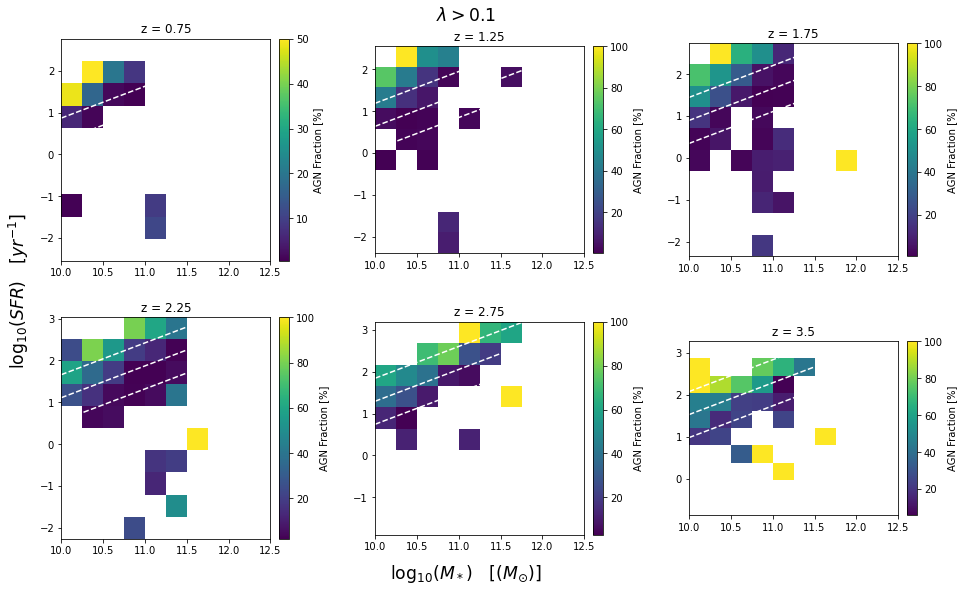

In [202]:
ret1_statT = []
ret2_statT = []

min_sfr = []
max_sfr = []
max_sm = []

for count, key in enumerate(all_r):
    #print('z:', key)
    sfr = all_r[key]['SFR'].copy()
    logsfr = np.log10(sfr[sfr != 0])
    #print('min sfr', np.min(logsfr))
    #print('max sfr', np.max(logsfr))
    
    min_sfr.append(np.min(logsfr))
    max_sfr.append(np.max(logsfr))

    sm = all_r[key]['sm'][sfr != 0].copy()
    logsm = np.log10(sm)
    
    max_sm.append(np.max(logsm))

    lmbda = all_r[key]['lambda'][sfr != 0].copy()

    for i in range(len(lmbda)):
        if lmbda[i] == 0:
            lmbda[i] = 1e-4

    loglmbda = np.log10(lmbda)

    Lx = all_r[key]['Lx'][sfr != 0].copy()

    for i in range(len(Lx)):
        if Lx[i] == 0:
            Lx[i] = 1e-1

    logLx = np.log10(Lx)
    
    def get_binned_fracs(y):
        logsfr_arr = np.asarray(logsfr)
        index = np.where(np.in1d(logsfr_arr, y))[0]
        frac_gt2, frac_gt1 = find_fracs3(loglmbda[index], logLx[index], 42)
        return frac_gt2, frac_gt1
    
    def get_frac1(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac1', frac1)
        return frac1

    def get_frac2(y):
        frac2, frac1 = get_binned_fracs(y)
        #print('frac2', frac2)
        return frac2

    ret1 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac1, bins=10)
    ret2 = binned_statistic_2d(logsm, logsfr, logsfr, statistic=get_frac2, bins=10)
    #print(ret1)
    
    ret1_statT.append(ret1.statistic.T)
    ret2_statT.append(ret2.statistic.T)
    
#print(ret1_statT)

#max_sfr[5] = 4

fig, ((ax1, ax3, ax5), (ax2, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.05)
cmap = plt.cm.get_cmap('viridis',1000)

#ax1.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
#ax1.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
#ax1.plot(x_points, qu_bounday[0], color='white', linestyle='--')

#im1 = ax1.imshow(ret2_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.5)
plot(ax1, 1, ret1_statT)
plot(ax2, 4, ret1_statT)

plot(ax3, 2, ret1_statT)
plot(ax4, 5, ret1_statT)

plot(ax5, 3, ret1_statT)
plot(ax6, 6, ret1_statT)
#ax2.plot(x_points, starburst_boundary[0], color='white', linestyle='--')
#ax2.plot(x_points, mainseq_boundary[0], color='white', linestyle='--')
#ax2.plot(x_points, qu_bounday[0], color='white', linestyle='--')
ax1.set_title('z = 0.75')
ax2.set_title('z = 2.25')

ax3.set_title('z = 1.25')
ax4.set_title('z = 2.75')

ax5.set_title('z = 1.75')
ax6.set_title('z = 3.5')


#im2 = ax2.imshow(ret1_statT[0], origin='lower', extent=(10,np.max(logsm),np.min(logsfr),np.max(logsfr)), cmap=cmap, aspect=0.5)

#ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
#ax1.set_ylabel('$\log_{10}(SFR) \quad [yr^{-1}]$')

#cax1 = ax1.inset_axes([1.04, 0, 0.05, 1])
#cax2 = ax2.inset_axes([1.04, 0, 0.05, 1])

#plt.colorbar(im1, label='AGN Fraction [%]', cax=cax1)
#plt.colorbar(im2, label='AGN Fraction [%]', cax=cax2)

fig.text(0.5, 0.1, '$\log_{10}(M_*) \quad [(M_{\odot})]$', ha='center', fontsize='xx-large')
fig.text(0.075, 0.5, '$\log_{10}(SFR) \quad [yr^{-1}]$', va='center', rotation='vertical', fontsize='xx-large')
fig.text(0.5, 0.875, '$\lambda > 0.1$', ha='center', fontsize='xx-large')

plt.show()